Script for plotting the output of the combined predictive coding network and head direction spiking neural network on the NRP. This work is documented in the living machines 2022 submission 'Integrating Spiking Neural Networks and Deep Learning Algorithms on the Neurorobotics Platform'.

This script plots a comparison between the head direction estimate of two simulation runs ie one ideothetic only and one corrected.

Required files: <br />
head_angle.csv
    - dataframe containing Time and head angle sampled at 50Hz <br />
all_spikes.csv 
    - dataframe containing Time and ID which are the spike times and corresponding cell number <br />
predictions.csv
    - dataframe containing predictions made by the predictive coding network <br />
    - most important are bump center which is the head direction estimate and error which is the prediciton error between the current SNN HD estimate fed back to the network and the prediction

These files are genrated by transfer functions in the NRP. One of each file is required for each simulation run.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
from collections import Counter
import os

N = 180

folder1 = 'data/idiothetic_only'
folder2 = 'data/no_dropout_non-negative'
if not os.path.exists(f'{folder2}/compare'):
    os.makedirs(f'{folder2}/compare')

c1 = 'steelblue'
c2 = 'red'

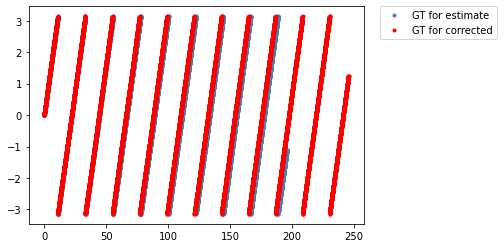

In [2]:
# load ground truth head angle from file

head_angle = pandas.read_csv(f'{folder1}/head_angle.csv')
time = np.array(head_angle['Time'])
ground_truth = np.array(head_angle['Theta'])
theta1 = (ground_truth+np.pi)%(2*np.pi)-np.pi
plt.plot(time,theta1,'.',label='GT for estimate',color=c1)

head_angle = pandas.read_csv(f'{folder2}/head_angle.csv')
time = np.array(head_angle['Time'])
ground_truth = np.array(head_angle['Theta'])
theta2 = (ground_truth+np.pi)%(2*np.pi)-np.pi
plt.plot(time,theta2,'.',label='GT for corrected',color=c2)
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)

In [3]:
def getModes(T,t,sp,N):
    modes = np.zeros(len(T))
    modes[:] = np.nan
    rates = np.zeros((N,len(time)))
    for i in range(len(T)-1):
        idx = (t>T[i])*(t<T[i+1]) # find all spikes in the bin
        lst = sp[np.where(idx)] # get the senders of those spikes
        occurence_count = Counter(lst) 
        mode = occurence_count.most_common(1) # find most common sender
        if len(mode):
            modes[i] = mode[0][0]

    step = (2*np.pi)/N
    modes = (modes*step) - np.pi
    return modes

In [4]:
dt = 20
T = time

# load spikes from file
spikes = pandas.read_csv(f'{folder1}/all_spikes.csv')
t = np.array(spikes['Time'])/1000
sp = np.array(spikes['ID']).astype(int)

#find the most active cell in each 40ms bin
modes1 = getModes(T,t,sp,N)

# load spikes from file
spikes = pandas.read_csv(f'{folder2}/all_spikes.csv')
t = np.array(spikes['Time'])/1000
sp = np.array(spikes['ID']).astype(int)

#find the most active cell in each 40ms bin
modes2 = getModes(T,t,sp,N)

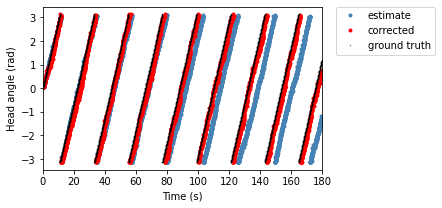

In [5]:
fig, ax = plt.subplots(1, 1,figsize=(5, 3),facecolor='w')

ax.plot(T,modes1,'.',label='estimate',color=c1)
ax.plot(T,modes2,'.',label='corrected',color=c2)
ax.plot(time[1:],theta2[1:],'.',markersize=.5,label='ground truth',color='black')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Head angle (rad)')
# plt.title(folder)
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)

ax.set_xlim([0,180])
plt.savefig(f'{folder2}/compare/figure_drift.png', bbox_inches='tight')

In [6]:
nanidx = np.where(~np.isnan(modes1[:-1]))
modes1 = modes1[nanidx]
T1=T[nanidx]
nanidx = np.where(~np.isnan(modes2[:-1]))
modes2 = modes2[nanidx]
T2=T[nanidx]

In [7]:
groundTruth = np.unwrap(theta2[:len(time)])

est1 = np.unwrap(modes1)
estimate1 = np.interp(time, T1, est1)
est2 = np.unwrap(modes2)
estimate2 = np.interp(time, T2, est2)

time = time[time<=180]
estimate1 = estimate1[:len(time)]
estimate2 = estimate2[:len(time)]
groundTruth = groundTruth[:len(time)]

1.2630309586306598 0.36891678465486766
2.4222250066876967 0.4325496594141569


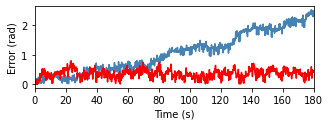

In [8]:
fig, ax = plt.subplots(1, 1,figsize=(5, 1.5),facecolor='w')

d1 = (groundTruth[1:]-estimate1[1:])
plt.plot(time[1:],abs(d1),label='estimate',color=c1)#, label = 'calculated error')
d2 = (groundTruth[1:]-estimate2[1:])
plt.plot(time[1:],abs(d2),label='corrected',color=c2)#, label = 'calculated error')
plt.xlabel('Time (s)')
plt.ylabel('Error (rad)')
plt.xlim([0,180])

RMSE1 = np.sqrt(np.sum(d1**2)/len(d1))
RMSE2 = np.sqrt(np.sum(d2**2)/len(d2))

print(RMSE1,RMSE2)
plt.savefig(f'{folder2}/compare/figure_error.png', bbox_inches='tight')

print(d1[-1],d2[-1])

error_times = time[1:]

In [9]:
predictions1 = pandas.read_csv(f'{folder1}/predictions.csv')
predictions2 = pandas.read_csv(f'{folder2}/predictions.csv')
predictions1

,Time,Bump Centre,Error,Obscured,cell1,cell2,cell3,cell4,cell5,cell6,...,cell172,cell173,cell174,cell175,cell176,cell177,cell178,cell179,cell180,Simulation_reset
0,0.42,93,6.948699,0,0.041083,0.045927,0.036291,0.044282,0.048511,0.049160,...,0.020525,0.030853,0.034780,0.025117,0.026228,0.029977,0.036703,0.027558,0.031030,NaN
1,0.70,96,6.150566,0,0.003787,0.021731,-0.007225,0.020425,0.016704,0.023060,...,-0.021073,-0.004630,-0.002663,-0.027131,-0.014489,-0.013635,0.000545,-0.000758,-0.002413,NaN
2,0.92,97,5.276541,0,-0.023630,0.004131,-0.044755,0.007202,-0.015956,0.004477,...,-0.040651,-0.019914,-0.019241,-0.054191,-0.048298,-0.040757,-0.012622,-0.012462,-0.018832,NaN
3,1.12,98,4.532093,0,-0.043144,-0.012511,-0.063866,0.002623,-0.037324,-0.010165,...,-0.051501,-0.026327,-0.029562,-0.073253,-0.068699,-0.064089,-0.018091,-0.012070,-0.036979,NaN
4,1.28,99,3.943076,0,-0.050750,-0.029504,-0.061237,0.002191,-0.045515,-0.021838,...,-0.055940,-0.029759,-0.035986,-0.080344,-0.070305,-0.084336,-0.014265,-0.007755,-0.061048,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,194.86,176,11.445626,0,0.098071,0.067842,0.040877,0.057939,0.061196,0.118269,...,0.051083,0.024052,0.019888,0.050034,-0.023506,-0.014002,-0.045816,-0.002919,0.021160,NaN
947,195.08,178,11.435236,0,0.081461,0.065559,0.036017,0.043947,0.034422,0.112063,...,0.051610,0.024291,0.021626,0.038979,-0.032163,-0.016950,-0.035807,-0.023783,0.011017,NaN
948,195.50,3,10.991105,0,0.064508,0.062385,0.027821,0.032002,0.006781,0.098169,...,0.039070,0.021696,0.020336,0.025591,-0.033384,-0.014738,-0.030399,-0.044529,0.001181,NaN
949,195.72,4,11.131412,0,0.054863,0.062374,0.012080,0.027622,-0.015723,0.080134,...,0.016270,0.019617,0.020993,0.010359,-0.032406,-0.015050,-0.030450,-0.048264,-0.003770,NaN


In [10]:
pred_time1 = np.array(predictions1.Time)
pred_error1 = np.array(predictions1.Error)
est1 = np.array(predictions1['Bump Centre'])

pred_time2 = np.array(predictions2.Time)
pred_error2 = np.array(predictions2.Error)
est2 = np.array(predictions2['Bump Centre'])

pred_time1 = pred_time1[pred_time1<=180]
pred_error1 = pred_error1[:len(pred_time1)]
pred_time2 = pred_time2[pred_time2<=180]
pred_error2 = pred_error2[:len(pred_time2)]

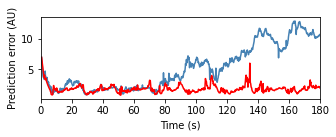

In [11]:
fig, ax = plt.subplots(1, 1,figsize=(5, 1.5),facecolor='w')

plt.plot(pred_time1,pred_error1,label='estimate',color=c1)
plt.plot(pred_time2,pred_error2,label='corrected',color=c2)
plt.xlabel('Time (s)')
plt.ylabel('Prediction error (AU)')
# plt.ylim([5,9])
plt.xlim([0,180])
plt.savefig(f'{folder2}/compare/figure_pcn_error.png', bbox_inches='tight')

0.0 0.40045766590389015


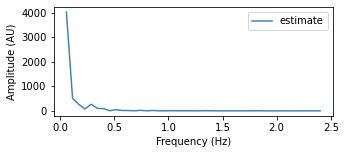

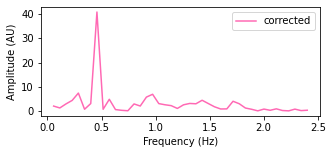

In [12]:
fig, ax = plt.subplots(1, 1,figsize=(5, 2),facecolor='w')

dt = .02
n = len(pred_time1)
fhat = np.fft.fft(pred_error1, n) #computes the fft
psd = fhat * np.conj(fhat)/n
freq = (1/(dt*n)) * np.arange(n) #frequency array
idxs_half = np.arange(1, np.floor(n/20), dtype=np.int32) #first half index
mx1 = np.argmax(np.abs(psd[idxs_half]))
mx1 = freq[mx1]
plt.plot(freq[idxs_half], np.abs(psd[idxs_half]),label='estimate',color='steelblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (AU)')
plt.legend()

fig, ax = plt.subplots(1, 1,figsize=(5, 2),facecolor='w')
dt = .02
n = len(pred_time2)
fhat = np.fft.fft(pred_error2, n) #computes the fft
psd = fhat * np.conj(fhat)/n
freq = (1/(dt*n)) * np.arange(n) #frequency array
idxs_half = np.arange(1, np.floor(n/20), dtype=np.int32) #first half index
mx2 = np.argmax(np.abs(psd[idxs_half]))
mx2 = freq[mx2]
plt.plot(freq[idxs_half], np.abs(psd[idxs_half]),label='corrected',color='hotpink')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (AU)')
print(mx1,mx2)
plt.legend()
# plt.savefig(f'{folder2}/compare/figure_fft.png', bbox_inches='tight')

Low freqency peak in estimate indicates the drift

Small peak in corrected refects some difference in the quality of the prediction at different head angles which is repeated as the robot rotates on the spot

Below are other analyses which were not included in the paper but might still be helpful at some point

In [13]:
# from scipy import signal

# sos = signal.butter(4, 0.3, 'lp', fs=len(pred_error1), output='sos')
# filtered = signal.sosfilt(sos, pred_error1)
# plt.plot(pred_time1, filtered)

# sos = signal.butter(4, 0.3, 'lp', fs=len(pred_error2), output='sos')
# filtered = signal.sosfilt(sos, pred_error2)
# plt.plot(pred_time2, filtered)
# plt.legend()

In [14]:
# dt = .02
# n = len(filtered)
# fhat = np.fft.fft(filtered, n) #computes the fft
# psd = fhat * np.conj(fhat)/n
# freq = (1/(dt*n)) * np.arange(n) #frequency array
# idxs_half = np.arange(1, np.floor(n/10), dtype=np.int32) #first half index

# ## Filter out noise
# threshold = 100
# psd_idxs = psd > threshold #array of 0 and 1
# psd_clean = psd * psd_idxs #zero out all the unnecessary powers
# fhat_clean = psd_idxs * fhat #used to retrieve the signal

# signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform

# plt.plot(freq[idxs_half], np.abs(psd[idxs_half]), color='b', lw=0.5, label='PSD noisy')
# plt.plot([0.3,0.3],[0,100])

In [15]:
# est = np.unwrap(est)
# groundTruth = np.unwrap(GT)

# fig, ax = plt.subplots(1, 1,figsize=(5, 3),facecolor='w')
# ax.plot(pred_time,est,label='estimate')
# ax.plot(pred_time,groundTruth,label='ground truth')
# plt.title(folder)
# # ax.title('unwraped estimate vs ground truth')

# hd_estimate = np.vstack([T,modes])
# # np.save(f'estimates/{file}_ideo_estimate.npy',hd_estimate)

In [16]:
# fig, ax = plt.subplots(1, 1,figsize=(5, 2),facecolor='w')

# d = (groundTruth-est)
# plt.plot(pred_time,abs(d))#, label = 'calculated error')
# plt.xlabel('Time (ms)')
# plt.ylabel('Error')
# # plt.ylim([0,2])


In [17]:
# error = abs(d)
# print(filtered.shape,error.shape)
# X = np.stack((filtered, error), axis=0)
# np.cov(X)

In [18]:
# idx = np.zeros(len(pred_time1))
# for i, var in enumerate(pred_time1):
#     v = np.where(error_times == var)
#     try:
#         idx[i] = v[0][0]
#     except:
#         idx[i] =np.nan
        
# idx = idx[~np.isnan(idx)].astype(int)

# ideo = d1[idx]
# allo = d2[idx]

# pred_error1 = pred_error1[:len(ideo)]
# pred_time1 = pred_time1[:len(ideo)]

# pred_error2 = pred_error2[:len(allo)]
# pred_time2 = pred_time2[:len(allo)]

In [19]:
# def calc_correlation(actual, predic):
#     a_diff = actual - np.mean(actual)
#     p_diff = predic - np.mean(predic)
#     numerator = np.sum(a_diff * p_diff)
#     denominator = np.sqrt(np.sum(a_diff ** 2)) * np.sqrt(np.sum(p_diff ** 2))
#     return numerator / denominator

# print(calc_correlation(ideo, pred_error1))
# print(calc_correlation(allo, pred_error2))
# print(calc_correlation(ideo, pred_error2))
# print(calc_correlation(allo, pred_error1))